### Slide:
https://docs.google.com/presentation/d/1ibzclaE3O77teAGG8VJOCnNWv6hUn-yecswBus8BhOg/edit?usp=sharing

# Detecting and mitigating age bias on credit decisions 

The goal of this tutorial is to introduce the basic functionality of AI Fairness 360.

### Biases and Machine Learning
A machine learning model makes predictions of an outcome for a particular instance. (Given an instance of a loan application, predict if the applicant will repay the loan.) The model makes these predictions based on a training dataset, where many other instances (other loan applications) and actual outcomes (whether they repaid) are provided. Thus, a machine learning algorithm will attempt to find patterns, or generalizations, in the training dataset to use when a prediction for a new instance is needed. (For example, one pattern it might discover is "if a person has salary > USD 40K and has outstanding debt < USD 5, they will repay the loan".) In many domains this technique, called supervised machine learning, has worked very well.

However, sometimes the patterns that are found may not be desirable or may even be illegal. For example, a loan repay model may determine that age plays a significant role in the prediction of repayment because the training dataset happened to have better repayment for one age group than for another. This raises two problems: **1) the training dataset may not be representative of the true population of people of all age groups, and 2) even if it is representative, it is illegal to base any decision on a applicant's age, regardless of whether this is a good prediction based on historical data.**

AI Fairness 360 is designed to help address this problem with _fairness metrics_ and _bias mitigators_.  Fairness metrics can be used to check for bias in machine learning workflows.  Bias mitigators can be used to overcome bias in the workflow to produce a more fair outcome. 

The loan scenario describes an intuitive example of illegal bias. However, not all undesirable bias in machine learning is illegal it may also exist in more subtle ways.  For example, a loan company may want a diverse portfolio of customers across all income levels, and thus, will deem it undesirable if they are making more loans to high income levels over low income levels.  Although this is not illegal or unethical, it is undesirable for the company's strategy.

As these two examples illustrate, a bias detection and/or mitigation toolkit needs to be tailored to the particular bias of interest.  More specifically, it needs to know the attribute or attributes, called _protected attributes_, that are of interest: race is one example of a _protected attribute_ and age is a second.

### The Machine Learning Workflow
To understand how bias can enter a machine learning model, we first review the basics of how a model is created in a supervised machine learning process.  



![image](https://ibmcode-staging.us-east.containers.mybluemix.net/site-content/uploads/2018/09/aif360-1.png)








First, the process starts with a _training dataset_, which contains a sequence of instances, where each instance has two components: the features and the correct prediction for those features.  Next, a machine learning algorithm is trained on this training dataset to produce a machine learning model.  This generated model can be used to make a prediction when given a new instance.  A second dataset with features and correct predictions, called a _test dataset_, is used to assess the accuracy of the model.
Since this test dataset is the same format as the training dataset, a set of instances of features and prediction pairs, often these two datasets derive from the same initial dataset.  A random partitioning algorithm is used to split the initial dataset into training and test datasets.

Bias can enter the system in any of the three steps above.  
1. The training data set may be biased in that its outcomes may be biased towards particular kinds of instances.  
2. The algorithm that creates the model may be biased in that it may generate models that are weighted towards particular features in the input. 
3. The test data set may be biased in that it has expectations on correct answers that may be biased.  These three points in the machine learning process represent points for testing and mitigating bias.  In AI Fairness 360 codebase, we call these points _pre-processing_, _in-processing_, and _post-processing_.



### install aif360 in conda env
```
conda create --name aif360 python=3.5
conda activate aif360
git clone https://github.com/IBM/AIF360
cd AIF360
pip install aif360
pip install -r requirements.txt
```

(to exit the env:
```
conda deactivate
```)

In [1]:
## make sure you're executing in the virtual env
import sys
sys.executable

'/Users/wyw/anaconda3/envs/aif360/bin/python'

### AI Fairness 360
We are now ready to utilize AI Fairness 360 (`aif360`) to detect and mitigate bias.  We will use the German credit dataset, splitting it into a training and test dataset.  We will look for bias in the creation of a machine learning model to predict if an applicant should be given credit based on various features from a typical credit application.  The protected attribute will be "Age", with "1" (older than or equal to 25) and "0" (younger than 25) being the values for the privileged and unprivileged groups, respectively.
For this first tutorial, we will check for bias in the initial training data, mitigate the bias, and recheck.  More sophisticated machine learning workflows are given in the author tutorials and demo notebooks in the codebase.

Here are the steps involved
#### Step 1: Write import statements
#### Step 2: Set bias detection options, load dataset, and split between train and test
#### Step 3: Compute fairness metric on original training dataset
#### Step 4: Mitigate bias by transforming the original dataset
#### Step 5: Compute fairness metric on transformed training dataset

### Step 1 Import Statements
As with any python program, the first step will be to import the necessary packages.  Below we import several components from the `aif360` package.  We import the GermanDataset, metrics to check for bias, and classes related to the algorithm we will use to mitigate bias.

In [2]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, DatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing,  DisparateImpactRemover
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from IPython.display import Markdown, display

import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns

import json
from collections import OrderedDict

### Step 2 Load dataset, specifying protected attribute, and split dataset into train and test
In Step 2 we load the initial dataset, setting the protected attribute to be age.  We then splits the original dataset into training and testing datasets.  Although we will use only  the training dataset in this tutorial, a normal workflow would also use a test dataset for assessing the efficacy (accuracy, fairness, etc.) during the development of a machine learning model.  Finally, we set two variables (to be used in Step 3) for the privileged (1) and unprivileged (0) values for the age attribute.  These are key inputs for detecting and mitigating bias, which will be Step 3 and Step 4.  

#### What is the German Credit Risk dataset?
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset:
https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

#### Loading dataset
<b>protected_attribute</b> means the attribute on which the bias can occur, basically the attribute you want to test bias for.

<b>privileged_classes</b> means a subset of protected attribute values which are considered privileged from a fairness perspective.

In the german dataset: Old (age >= 25) are the privileged class and Young (age < 25) are the unprivileged class.

Here we have binary membership in a protected group (age) and this is a binary classification problem.

Here, age -> sensitive attribute and Old (age >= 25) is the protected group -> historically systematic advantage group.

The dataset is already encoded as the algorithms need the dataset to have numerical values and not categorical.

In [4]:
dataset_orig = GermanDataset(protected_attribute_names=['age'],           # this dataset also contains protected
                                                                          # attribute for "sex" which we do not
                                                                          # consider in this evaluation
                             privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
                             features_to_drop=['personal_status', 'sex']) # ignore sex-related attributes

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]



In [5]:
dataset_orig.feature_names

['month',
 'credit_amount',
 'investment_as_income_percentage',
 'residence_since',
 'age',
 'number_of_credits',
 'people_liable_for',
 'status=A11',
 'status=A12',
 'status=A13',
 'status=A14',
 'credit_history=A30',
 'credit_history=A31',
 'credit_history=A32',
 'credit_history=A33',
 'credit_history=A34',
 'purpose=A40',
 'purpose=A41',
 'purpose=A410',
 'purpose=A42',
 'purpose=A43',
 'purpose=A44',
 'purpose=A45',
 'purpose=A46',
 'purpose=A48',
 'purpose=A49',
 'savings=A61',
 'savings=A62',
 'savings=A63',
 'savings=A64',
 'savings=A65',
 'employment=A71',
 'employment=A72',
 'employment=A73',
 'employment=A74',
 'employment=A75',
 'other_debtors=A101',
 'other_debtors=A102',
 'other_debtors=A103',
 'property=A121',
 'property=A122',
 'property=A123',
 'property=A124',
 'installment_plans=A141',
 'installment_plans=A142',
 'installment_plans=A143',
 'housing=A151',
 'housing=A152',
 'housing=A153',
 'skill_level=A171',
 'skill_level=A172',
 'skill_level=A173',
 'skill_level=A17

In [6]:
print("Original one hot encoded german dataset shape: ",dataset_orig.features.shape)
print("Train dataset shape: ", dataset_orig_train.features.shape)
print("Test dataset shape: ", dataset_orig_test.features.shape)

Original one hot encoded german dataset shape:  (1000, 57)
Train dataset shape:  (700, 57)
Test dataset shape:  (300, 57)


In [7]:
print("Protected Attribute set: ", dataset_orig.protected_attribute_names)

Protected Attribute set:  ['age']


<b>metadata</b> : returns a dict which contains details about the creation of the dataset.

In [8]:
dataset_orig.metadata

<b>convert_to_dataframe</b> : converts a structured dataset to a pandas dataframe.

<i>de_dummy_code = True</i> : converts dummy-coded columns to categories. 

<i>set_category = True</i> : sets the de-dummy coded features to categorical type.

This method returns a dict and a dataframe.

The dict: Contains Attributes. It also contains additional information pulled from the dataset such as feature_names, label_names, protected_attribute_names, instance_names, instance_weights, privileged_protected_attributes, unprivileged_protected_attributes. 

In [11]:
df, dict_df = dataset_orig.convert_to_dataframe(de_dummy_code = True)


In [12]:
print(type(df), type(dict_df))

<class 'pandas.core.frame.DataFrame'> <class 'dict'>


In [13]:
df.shape

(1000, 20)

In [14]:
df.head(5)

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,credit,status,credit_history,purpose,savings,employment,other_debtors,property,installment_plans,housing,skill_level,telephone,foreign_worker
0,6.0,1169.0,4.0,4.0,Male,2.0,1.0,Good Credit,A11,A34,A43,A65,A75,A101,A121,A143,A152,A173,A192,A201
1,48.0,5951.0,2.0,2.0,Female,1.0,1.0,Bad Credit,A12,A32,A43,A61,A73,A101,A121,A143,A152,A173,A191,A201
2,12.0,2096.0,2.0,3.0,Male,1.0,2.0,Good Credit,A14,A34,A46,A61,A74,A101,A121,A143,A152,A172,A191,A201
3,42.0,7882.0,2.0,4.0,Male,1.0,2.0,Good Credit,A11,A32,A42,A61,A74,A103,A122,A143,A153,A173,A191,A201
4,24.0,4870.0,3.0,4.0,Male,2.0,2.0,Bad Credit,A11,A33,A40,A61,A73,A101,A124,A143,A153,A173,A191,A201


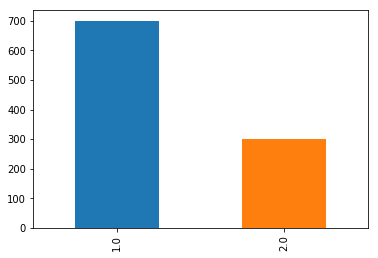

In [16]:
df['credit'].value_counts().plot(kind='bar')

### Step 3 Compute fairness metric on original training dataset
Now that we've identified the protected attribute 'age' and defined privileged and unprivileged values, we can use aif360 to detect bias in the dataset.  

##### Fairness Measure (1): Mean Difference (statistical parity)
1. Definition

Define $X$ as a categorical attribute that takes on two values: 0,1 (priviledged group). <br>
A score $S=S(x)$ satisfies statistical parity at a threshold $s_{thres}$ if the proportion of individuals classified as high-risk is the same for each group

$\Pr(S>s_{thres})| X = 0) = \Pr(S>s_{thres})| X = 1)$ 

Mean Difference = $ \Pr(S>s_{thres})| X = 0) - \Pr(S>s_{thres})| X = 1)$

2. Ideal value of Mean Difference 

The ideal value of this metric is 0.

A value < 0 indicates less favorable outcomes for the unprivileged groups.  This is implemented in the method called mean_difference on the BinaryLabelDatasetMetric class.  The code below performs this check and displays the output, showing that the difference is -0.169905.

In [16]:
type(dataset_orig_train)

aif360.datasets.german_dataset.GermanDataset

In [17]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.169905


##### Fairness measure (2): Disparate Impact

1. Definition

Denote $D$ as a binary decision where 'YES' is a desired outcome and X as protected attribute that takes value 0 or 1 (priviledged). We say $D$ has Disparate Impact if: $$ \frac{\Pr(D = Yes | X = 0)}{\Pr(D = Yes| X = 1)} \leq 0.8$$
(M/ Feldman, S. Friedler, J. Moeller, C. Scheidegger, S. Venkatasubramanian; KDD 2015)

2. Ideal value of the metric

The ideal value of this metric is 1.0.

A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.

In [18]:
display(Markdown("#### Original training dataset"))
print("Disparate Impact = %f" % metric_orig_train.disparate_impact())

#### Original training dataset

Disparate Impact = 0.766430


#### Explainers

###### Text Explanations

In [19]:
text_expl = MetricTextExplainer(metric_orig_train)
json_expl = MetricJSONExplainer(metric_orig_train)

In [20]:
print(text_expl.mean_difference())

Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.1699054740619017


In [21]:
print(text_expl.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.7664297113013201


### Step 4 Mitigate bias by transforming the original dataset
The previous step showed that the privileged group was getting 17% more positive outcomes in the training dataset.   Since this is not desirable, we are going to try to mitigate this bias in the training dataset.  As stated above, this is called _pre-processing_ mitigation because it happens before the creation of the model.  

AI Fairness 360 implements several pre-processing mitigation algorithms.  We will choose the Reweighing algorithm [1], which is implemented in the `Reweighing` class in the `aif360.algorithms.preprocessing` package.  This algorithm will transform the dataset to have more equity in positive outcomes on the protected attribute for the privileged and unprivileged groups.

We then call the fit and transform methods to perform the transformation, producing a newly transformed training dataset (dataset_transf_train).

`[1] F. Kamiran and T. Calders,  "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012.`

<b>Reweighing:</b> Reweighing is a data preprocessing technique that recommends generating weights for the training examples in each (group, label) combination differently to ensure fairness before classification. The idea is to apply appropriate weights to different tuples in the training dataset to make the training dataset discrimination free with respect to the sensitive attributes. Instead of reweighing, one could also apply techniques (non-discrimination constraints) such as suppression (remove sensitive attributes) or massaging the dataset — modify the labels (change the labels appropriately to remove discrimination from the training data). However, the reweighing technique is more effective than the other two mentioned earlier.

In [8]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

### Step 5 Compute fairness metric on transformed dataset
Now that we have a transformed dataset, we can check how effective it was in removing bias by using the same metric we used for the original training dataset in Step 3.  Once again, we use the function mean_difference in the BinaryLabelDatasetMetric class.   We see the mitigation step was very effective, the difference in mean outcomes is now 0.0.  So we went from a 17% advantage for the privileged group to equality in terms of mean outcome.

In [9]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [10]:
display(Markdown("#### Transformed training dataset"))
print("Disparate Impact = %f" % metric_transf_train.disparate_impact())

#### Transformed training dataset

Disparate Impact = 1.000000


### How robust is Reweighing?
1. generating 10 train-test split
2. accuracy-fairness tradeoffs between logistic regression and random forests

In [11]:
### generating 10 train-test split
data_name = 'german'
all_train = {}; all_test = {};
for i in range(10):
    all_train[i], all_test[i] = dataset_orig.split([0.7], shuffle=True)

In [12]:
i = 0
all_train[i].features

array([[1.200e+01, 2.859e+03, 4.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.800e+01, 1.943e+03, 4.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.400e+01, 3.123e+03, 4.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.200e+01, 1.331e+03, 2.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [4.800e+01, 3.060e+03, 4.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.800e+01, 1.445e+03, 4.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [14]:
#progress bar
from tqdm import tqdm_notebook as tqdm

#ML algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
# avg DI 
dataset_di = []
for i in tqdm(range(10)): #loop over 10 datasets
    fair_metrics = BinaryLabelDatasetMetric(all_test[i], unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)
    dataset_di.append(fair_metrics.disparate_impact())

print('Dataset DI: ', np.mean(dataset_di), np.std(dataset_di))


Dataset DI:  0.8226023883602377 0.06639671887448659


In [29]:
def reweigh_experiment(clf):
    di = []
    accuracy = []
    for i in range(10):

        protected_index = dataset_orig.feature_names.index('age')
        RW = Reweighing(unprivileged_groups=unprivileged_groups,
                        privileged_groups=privileged_groups)
        train_repaired = RW.fit_transform(all_train[i])
        test = all_test[i]

        # Delete the protected feature from the data while fitting the end clasifier
        X_train = np.delete(train_repaired.features, protected_index, axis=1)
        X_test = np.delete(test.features, protected_index, axis=1)

        # flatten array
        y_train = train_repaired.labels.ravel()

        if clf == 'lr':
            clf = LogisticRegression(class_weight='balanced', solver = 'lbfgs', max_iter = 200)
        elif clf == 'forest':
            clf = RandomForestClassifier(n_estimators = 5, min_samples_leaf = 10)

        clf.fit(X_train, y_train)

        test_repaired_pred = test.copy()
        test_repaired_pred.labels = clf.predict(X_test)
        fair_metrics = BinaryLabelDatasetMetric(test_repaired_pred, 
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)
        clf_metrics = ClassificationMetric(test, test_repaired_pred, 
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
        di.append(fair_metrics.disparate_impact())
        accuracy.append(clf_metrics.accuracy())
    return di, accuracy

In [30]:
clf = 'lr'
di_lr, accuracy_lr = reweigh_experiment(clf)

In [31]:
clf = 'forest'
di_forest, accuracy_forest = reweigh_experiment(clf)

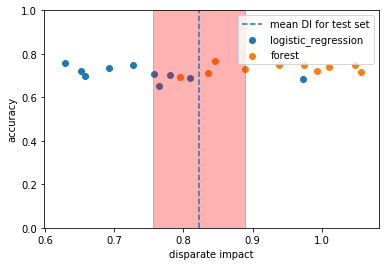

In [32]:
%matplotlib inline
plt.scatter(di_lr, accuracy_lr, label = 'logistic_regression')
plt.scatter(di_forest, accuracy_forest, label = 'forest')
plt.axvspan(np.mean(dataset_di)-np.std(dataset_di), np.mean(dataset_di)+np.std(dataset_di), 
            alpha=0.3, color='red')
plt.plot([np.mean(dataset_di), np.mean(dataset_di)], [0,1], '--', label = 'mean DI for test set')
plt.ylim([0,1])
plt.xlabel('disparate impact')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Summary
The purpose of this tutorial is to give a new user to bias detection and mitigation a gentle introduction to some of the functionality of AI Fairness 360.  A more complete use case would take the next step and see how the transformed dataset impacts the accuracy and fairness of a trained model.  This is implemented in the demo notebook in the examples directory of toolkit, called demo_reweighing_preproc.ipynb.  I highly encourage readers to view that notebook as it is  generalization and extension of this simple tutorial.

There are many metrics one can use to detect the presence of bias. AI Fairness 360 provides many of them for your use. Since it is not clear which of these metrics to use, we also provide some guidance. Likewise, there are many different bias mitigation algorithms one can employ, many of which are in AI Fairness 360. Other tutorials will demonstrate the use of some of these metrics and mitigations algorithms.

As mentioned earlier, both fairness metrics and mitigation algorithms can be performed at various stages of the machine learning pipeline.  We recommend checking for bias as often as possible, using as many metrics are relevant for the application domain.  We also recommend incorporating bias detection in an automated continuous integration pipeline to ensure bias awareness as a software project evolves.

### Useful Links

AIF360 Git: https://github.com/IBM/AIF360

AIF360 Homepage: https://aif360.mybluemix.net/

Example Code Pattern: https://github.com/IBM/ensure-loan-fairness-aif360

API documentation: https://aif360.readthedocs.io/en/latest/modules/algorithms.html

AIF360 Overview Video: https://www.youtube.com/watch?v=X1NsrcaRQTE

Reweighing paper:https://link.springer.com/content/pdf/10.1007%2Fs10115-011-0463-8.pdf